In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cmasher as cmr
import functions as fn
import plotting_scripts as ps


## Clustering plot example

In [2]:
# Parameters
n_points = 500
center = (0, 0)
clusters = [
    {'center': center, 'n_points': n_points, 'spread': 0.5},  # Tight
    {'center': center, 'n_points': n_points, 'spread': 1.5},  # Medium
    {'center': center, 'n_points': n_points, 'spread': 6}   # Very loose
]

bins = np.linspace(0, 2.0, 30)

# Generate clusters (same center, different spread)
points = [fn.generate_cluster(cl['center'], cl['n_points'], cl['spread'], seed=i)
          for i, cl in enumerate(clusters)]
spreads = [cl['spread'] for cl in clusters]  # for labeling

# Shared bounds for RR only
x_all = np.concatenate([x for x, y in points])
y_all = np.concatenate([y for x, y in points])
bounds = ((x_all.min(), x_all.max()), (y_all.min(), y_all.max()))


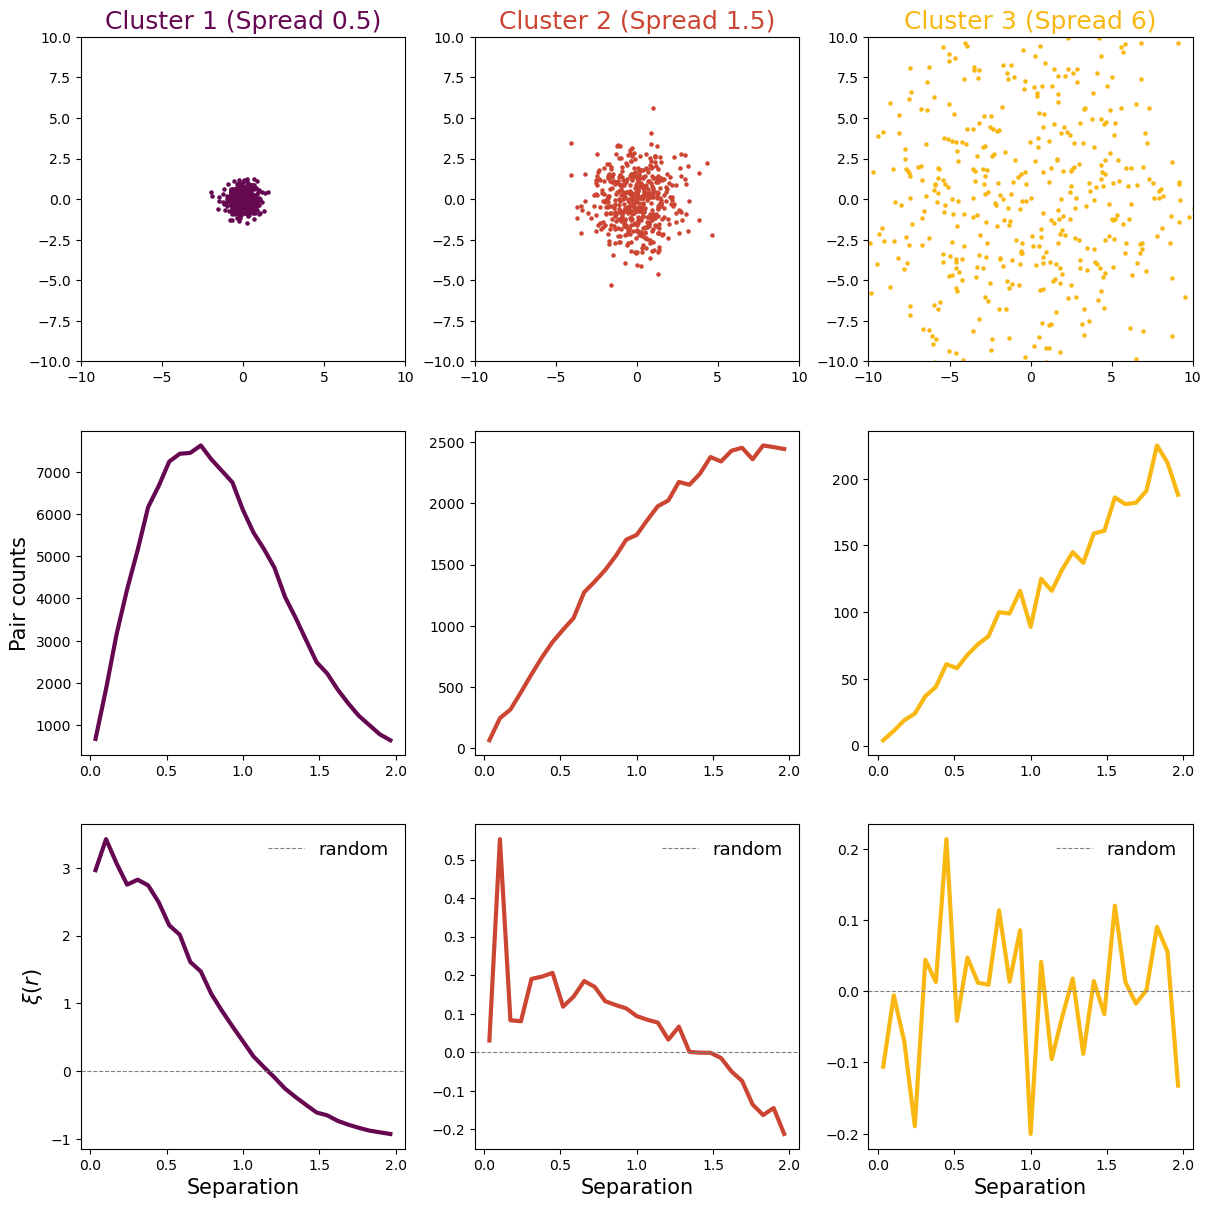

In [3]:
# Plot
xlim_fixed = (-10, 10)
ylim_fixed = (-10, 10)

# Colors from cmr.rainforest
colors = cmr.take_cmap_colors('cmr.pride_r', len(clusters), cmap_range=(0.1, 0.45), return_fmt='hex')
lw = 3
labelsize = 15

# Plot
fig, axs = plt.subplots(
    3, 3,
    figsize=(12, 12),
    constrained_layout=True,
    gridspec_kw={'wspace': 0.01, 'hspace': 0.01}  # smaller gaps between plots
)

for i, (x, y) in enumerate(points):
    r, dd, xi = fn.compute_2pcf_and_xi(x, y, bins, bounds=bounds, n_random=5000)
    color = colors[i]

    axs[0, i].scatter(x, y, s=5, color=color)
    axs[0, i].set_xlim(xlim_fixed)
    axs[0, i].set_ylim(ylim_fixed)
    axs[0, i].set_box_aspect(1)
    axs[0, i].set_title(f"Cluster {i+1} (Spread {spreads[i]})", color=color, fontsize=labelsize+3)

    axs[1, i].plot(r, dd, color=color, lw=lw)
    axs[1, i].set_ylabel("Pair counts", fontsize=labelsize)
    axs[1, i].set_box_aspect(1)

    axs[2, i].plot(r, xi, color=color, lw=lw)
    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=0.8, label="random")
    axs[2, i].set_ylabel(r"$\xi(r)$", fontsize=labelsize)
    axs[2, i].set_xlabel("Separation", fontsize=labelsize)
    axs[2, i].set_box_aspect(1)
    axs[2, i].legend(loc='upper right', fontsize=labelsize-2, frameon=False)

    if i > 0:
        axs[0, i].set_ylabel("")
        axs[1, i].set_ylabel("")
        axs[2, i].set_ylabel("")
plt.savefig(f"plots_output/2pcf_clusters.png", dpi=300, bbox_inches='tight')
plt.show()


## Script for Plotly for the website


In [1]:
import numpy as np
import plotly.graph_objects as go
import cmasher as cmr
import panel as pn
import functions as fn  # my custom functions

pn.extension('plotly')

# Config
xlim_fixed = (-10, 10)
ylim_fixed = (-10, 10)
lw = 3
labelsize = 15
n_points = 500
center = (0, 0)

# Initial bounds
x, y = fn.generate_cluster(center, n_points, spread=1.0, seed=42)
bounds = ((x.min(), x.max()), (y.min(), y.max()))

# Updated discrete options
spread_values = [round(val, 1) for val in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 5.0]]
max_sep_values = [int(val) for val in range(2, 11, 2)]
num_bins_values = [int(val) for val in range(10, 51, 5)]

# Discrete Sliders
spread_slider = pn.widgets.DiscreteSlider(name='Spread', options=spread_values, value=1.0)
max_sep_slider = pn.widgets.DiscreteSlider(name='Max Separation', options=max_sep_values, value=2)
num_bins_slider = pn.widgets.DiscreteSlider(name='Number of Bins', options=num_bins_values, value=20)

@pn.depends(spread=spread_slider, max_sep=max_sep_slider, num_bins=num_bins_slider)
def update_plot(spread, max_sep, num_bins):
    x, y = fn.generate_cluster(center, n_points, spread, seed=42)
    color = "#7ecaf6"
    bins = np.linspace(0, max_sep, num_bins)
    r, dd, xi = fn.compute_2pcf_and_xi(x, y, bins, bounds=bounds, n_random=5000)

    fig_cluster = go.Figure().add_trace(go.Scatter(
        x=x, y=y, mode='markers',
        marker=dict(size=7, color=color, line=dict(color='black', width=1)),
        name='Cluster'
    )).update_layout(
        title=f"Cluster (Spread {spread:.2f})",
        xaxis=dict(range=xlim_fixed, scaleanchor='y', scaleratio=1, title='X', showgrid=False),
        yaxis=dict(range=ylim_fixed, title='Y', showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40)
    )

    fig_dd = go.Figure().add_trace(go.Scatter(
        x=r, y=dd, mode='lines+markers',
        line=dict(color=color, width=lw),
        marker=dict(line=dict(color='black', width=1)),
        name='Pair counts'
    )).update_layout(
        title="Pair Counts", xaxis_title="Separation", yaxis_title="Pair Counts",
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40)
    )

    fig_xi = go.Figure().add_trace(go.Scatter(
        x=r, y=xi, mode='lines+markers',
        line=dict(color=color, width=lw),
        marker=dict(line=dict(color='black', width=1)),
        name='ξ(r)'
    )).add_hline(y=0, line=dict(color='gray', dash='dash')).update_layout(
        title="Two-Point Correlation Function", xaxis_title="Separation", yaxis_title="ξ(r)",
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40), legend=dict(font=dict(size=labelsize - 2))
    )

    return pn.Row(
        pn.pane.Plotly(fig_cluster, sizing_mode='stretch_width'),
        pn.pane.Plotly(fig_dd, sizing_mode='stretch_width'),
        pn.pane.Plotly(fig_xi, sizing_mode='stretch_width')
    )

# Sliders layout
sliders = pn.Column(spread_slider, max_sep_slider, num_bins_slider, pn.Spacer(height=20))
centered_sliders = pn.Row(pn.Spacer(width=100), sliders, pn.Spacer(width=100))

# Inject Google Fonts for Source Sans Pro
font_import = """
<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;700&display=swap" rel="stylesheet">
<style>
body, h1, h2, h3, h4, h5, p, li {
    font-family: 'Source Sans Pro', sans-serif;
}
</style>
"""
font_import_pane = pn.pane.HTML(font_import, sizing_mode='stretch_width')

# Concise intro at the top
intro_html = """
<h2>Interactive 2PCF Clustering Demo</h2>
<p style="font-size: 10pt; line-height: 1.4;">
Explore how the spatial clustering of points (representing galaxies) depends on the spread parameter, affecting their "clumpiness." Adjust the sliders and observe changes in the plots below.
</p>
"""

# Detailed description below
detailed_html = """
<p style="font-size: 10pt; line-height: 1.4;">
This visualization demonstrates a fundamental concept in cosmology: the <b>clustering of galaxies</b> in the Universe. In the top-left panel, each point represents a "galaxy" in a 2D slice of the cosmos. The <b>spread</b> parameter controls how closely packed or scattered these points are. Smaller spreads produce tighter clusters (mimicking galaxy groups or clusters), while larger spreads result in a more uniform, random distribution. This mimics how large-scale structures form in the real Universe—galaxies clump under gravity, creating dense regions surrounded by emptier voids.
</p>

<p style="font-size: 10pt; line-height: 1.4;">
In the middle panel, we visualize the <b>pair counts</b> of these points as a function of their separation. Each pair of points represents a possible "galaxy pair," and the total number of unique pairs increases rapidly with the number of points (for example, 500 points produce 124,750 possible pairs). We bin these pairs based on how far apart they are and count how many fall into each separation bin. Peaks in the pair counts highlight distances where clustering is strongest.
</p>

<p style="font-size: 10pt; line-height: 1.4;">
In the bottom panel, we display the <b>two-point correlation function ξ(r)</b>. This function quantifies how much more likely (or less likely) it is to find a pair of galaxies at a given separation compared to a completely random distribution. A positive ξ(r) indicates enhanced clustering at that separation, while a negative ξ(r) suggests galaxies avoid each other at that scale. The dashed line at ξ(r) = 0 represents a uniform, random distribution with no clustering. Deviations from this line highlight the presence of structure in the point distribution.
</p>

<p style="font-size: 10pt; line-height: 1.4;">
With this tool, you can:
<ul style="font-size: 10pt; line-height: 1.4;">
<li><b>Adjust the spread</b> to see how the clustering pattern changes from tight clumps to a near-random arrangement.</li>
<li><b>Control the maximum separation</b> to examine clustering over different scales, from small groups to large-scale cosmic patterns.</li>
<li><b>Change the number of bins</b> to fine-tune the resolution of the separation and clustering analysis.</li>
</ul>
This simple demonstration mirrors techniques cosmologists use to study the Universe’s large-scale structure—from galaxy clustering to understanding dark matter and dark energy.
</p>

<p style="font-size: 10pt; line-height: 1.4;">
Try it out and observe how the <b>pair counts</b> and <b>ξ(r)</b> plots respond to your adjustments, revealing the underlying structure of this simulated Universe!
</p>
"""
intro_pane = pn.pane.HTML(intro_html, sizing_mode='stretch_width')
detailed_pane = pn.pane.HTML(detailed_html, sizing_mode='stretch_width')

# Final dashboard layout
dashboard = pn.Column(
    font_import_pane,  # Google Font import
    intro_pane,
    pn.Spacer(height=20),
    centered_sliders,
    pn.Spacer(height=40),
    update_plot,
    pn.Spacer(height=30),
    detailed_pane
)

# Save and serve
dashboard.save(
    "htmls/cluster_app_niko.html",
    embed=True,
    embed_states={
        "spread": spread_values,
        "max_sep": max_sep_values,
        "num_bins": num_bins_values
    }
)
dashboard.servable()


Column
    [0] HTML(str, sizing_mode='stretch_width')
    [1] HTML(str, sizing_mode='stretch_width')
    [2] Spacer(height=20)
    [3] Row
        [0] Spacer(width=100)
        [1] Column
            [0] DiscreteSlider(name='Spread', options=[0.1, 0.2, 0.5, ...], value=1.0)
            [1] DiscreteSlider(formatter='%d', name='Max Separation', options=[2, 4, 6, 8, 10], value=2)
            [2] DiscreteSlider(formatter='%d', name='Number of Bins', options=[10, 15, 20, 25, ...], value=20)
            [3] Spacer(height=20)
        [2] Spacer(width=100)
    [4] Spacer(height=40)
    [5] ParamFunction(function, _pane=Row, defer_load=False)
    [6] Spacer(height=30)
    [7] HTML(str, sizing_mode='stretch_width')

In [ ]:
dashboard

## testing multiple structures

In [ ]:
# --- Parameters ---
n_cluster = 500
n_void = 10  # sparse region = underdense "void"
n_background = 500
xlim, ylim = (-10, 10), (-10, 10)
void_center = (-3, 0)
void_radius = 2

# --- Clusters ---
cluster1 = fn.generate_cluster(center=(-7.5, -7.5), n_points=n_cluster, spread=0.5)
cluster2 = fn.generate_cluster(center=(1, 5), n_points=n_cluster, spread=0.8)

# --- Void (sparse cluster) ---
void = fn.generate_cluster(center=void_center, n_points=n_void, spread=0.5)

# --- Filaments ---
fil1 = fn.generate_filament(start=(5, 0), end=(9, -5), n_points=400, thickness=0.1)
fil2 = fn.generate_filament(start=(0, 4), end=(5, 4.5), n_points=200, thickness=0.15)

# --- Background (uniform + clipped by void) ---
bg = fn.generate_random_background(n_background, xlim=xlim, ylim=ylim)
bg = fn.mask_void_region(*bg, center=void_center, radius=void_radius)

# --- Colors ---
colors = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.2, 0.8), return_fmt='hex')

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 5))

# Plot clusters
ax.scatter(*cluster1, s=5, color=colors[0], label="Cluster 1")
ax.scatter(*cluster2, s=5, color=colors[1], label="Cluster 2")

# Plot void (sparse cluster)
ax.scatter(*void, s=5, color=colors[2], label="Void Region (Underdense)")

# Plot filaments
ax.scatter(*fil1, s=5, color=colors[3], label="Filament")
#ax.scatter(*fil2, s=5, color=colors[3])

# Plot background
ax.scatter(*bg, s=5, color='gray', alpha=0.3, label="Background")

# Draw void outline
void_circle = Circle(void_center, void_radius, edgecolor='black',
                     facecolor='none', linestyle='--', linewidth=1.5, label="Void Boundary")
ax.add_patch(void_circle)

# Plot settings
ax.set_aspect('equal')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Mock Cosmic Web with Clusters, Filaments, and Void", fontsize=14)
ax.legend(loc='upper left', fontsize=10)
plt.savefig(f"plots_output/mock_universe2.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
# --- Combine all components into one mock catalog ---
x_all_mock = np.concatenate([
    cluster1[0], cluster2[0], void[0], fil1[0], fil2[0], bg[0]
])
y_all_mock = np.concatenate([
    cluster1[1], cluster2[1], void[1], fil1[1], fil2[1], bg[1]
])

# --- Define separation bins ---
bins = np.linspace(0, 5, 30)  # Adjust bin range/size as needed

# Compute 2PCF and get pair histogram (DD)
r, dd_hist, xi = fn.compute_2pcf_and_xi(x_all_mock, y_all_mock, bins=bins, n_random=5000, bounds=(xlim, ylim))

# Plot DD pair counts
plt.figure(figsize=(6, 4))
plt.bar(r, dd_hist, width=np.diff(bins), align='center', color='royalblue', alpha=0.7, fill=False)
plt.xlabel("Separation")
plt.ylabel("Pair Counts (DD)")
plt.title("Histogram of Pairwise Separations (DD)")
plt.tight_layout()
plt.show()

# Plot xi(r)
plt.figure(figsize=(6, 4))
plt.plot(r, xi, marker='o', color='black', label=r"$\xi(r)$")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel("Separation")
plt.ylabel(r"$\xi(r)$")
plt.title("2-Point Correlation Function")
plt.legend()
plt.tight_layout()
plt.show()



## Shear

In [ ]:
nonzero_shear = 2
shears = [(0.0, 0.0), (nonzero_shear, 1.5), (0.0, nonzero_shear*2)]  # Example shears

In [ ]:
box_size = 5
xlim_fixed = (-box_size, box_size)
ylim_fixed = (-box_size, box_size)
bins = np.linspace(0, 2.0, 20)
colors = cmr.take_cmap_colors('cmr.pride_r', len(points), cmap_range=(0.1, 0.45), return_fmt='hex')
lw = 3
labelsize = 15
style = "ellipse"
scale = 0.2
stretch = 2

fig, axs = plt.subplots(3, 3, figsize=(12, 12),
                        constrained_layout=True,
                        gridspec_kw={'wspace': 0.01, 'hspace': 0.01})


for i, (x, y) in enumerate(points):
    color = colors[i]
    e1, e2 = fn.add_shapes(x, shear=shears[i])

    # Compute xi+, xi-
    r, etet, exex = fn.compute_tangential_and_cross(x, y, e1, e2)
    r_centers, xi_plus, xi_minus = fn.bin_2pcf(r, etet, exex, bins)

    # Top row: Shape field
    ps.plot_shapes(x, y, e1, e2, axs[0, i], style=style, scale=scale, color=color, stretch=stretch)
    axs[0, i].set_xlim(xlim_fixed)
    axs[0, i].set_ylim(ylim_fixed)
    axs[0, i].set_box_aspect(1)
    axs[0, i].set_title(f"Shear {i+1}", color=color, fontsize=labelsize + 3)

    # Middle row: xi+
    axs[1, i].plot(r_centers, xi_plus, color=color, lw=lw)
    axs[1, i].set_ylabel(r"$\xi_+$", fontsize=labelsize)
    axs[1, i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[1, i].set_box_aspect(1)

    # Bottom row: xi-
    axs[2, i].plot(r_centers, xi_minus, color=color, lw=lw)
    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[2, i].set_ylabel(r"$\xi_-$", fontsize=labelsize)
    axs[2, i].set_xlabel("Separation", fontsize=labelsize)
    axs[2, i].set_box_aspect(1)

    # Remove redundant labels for 2nd/3rd column
    if i > 0:
        axs[0, i].set_ylabel("")
        axs[1, i].set_ylabel("")
        axs[2, i].set_ylabel("")

plt.savefig(f"plots_output/xi_shear_configs_{style}.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
nonzero_shear = 2
shears = [(0.0, 0.0), (nonzero_shear, 1.5), (0.0, nonzero_shear*2)]  # Example shears

box_size = 5
xlim_fixed = (-box_size, box_size)
ylim_fixed = (-box_size, box_size)
bins = np.linspace(0, 2.0, 20)
colors = cmr.take_cmap_colors('cmr.pride_r', len(points), cmap_range=(0.1, 0.45), return_fmt='hex')
lw = 3
labelsize = 15
style = "ellipse"
mode = "radial"
scale = 0.2
stretch = 2

fig, axs = plt.subplots(3, 3, figsize=(12, 12),
                        constrained_layout=True,
                        gridspec_kw={'wspace': 0.01, 'hspace': 0.01})


for i, (x, y) in enumerate(points):
    color = colors[i]
    e1, e2 = fn.assign_realistic_shear(x, y, center=(0, 0), amplitude=0.05, sigma=4.0,
                             mode=mode, noise_std=0.01)

    # Compute xi+, xi-
    r, etet, exex = fn.compute_tangential_and_cross(x, y, e1, e2)
    r_centers, xi_plus, xi_minus = fn.bin_2pcf(r, etet, exex, bins)

    # Top row: Shape field
    ps.plot_shapes(x, y, e1, e2, axs[0, i], style=style, scale=scale, color=color, stretch=stretch)
    axs[0, i].set_xlim(xlim_fixed)
    axs[0, i].set_ylim(ylim_fixed)
    axs[0, i].set_box_aspect(1)
    axs[0, i].set_title(f"Shear {i+1}", color=color, fontsize=labelsize + 3)

    # Middle row: xi+
    axs[1, i].plot(r_centers, xi_plus, color=color, lw=lw)
    axs[1, i].set_ylabel(r"$\xi_+$", fontsize=labelsize)
    axs[1, i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[1, i].set_box_aspect(1)

    # Bottom row: xi-
    axs[2, i].plot(r_centers, xi_minus, color=color, lw=lw)
    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[2, i].set_ylabel(r"$\xi_-$", fontsize=labelsize)
    axs[2, i].set_xlabel("Separation", fontsize=labelsize)
    axs[2, i].set_box_aspect(1)

    # Remove redundant labels for 2nd/3rd column
    if i > 0:
        axs[0, i].set_ylabel("")
        axs[1, i].set_ylabel("")
        axs[2, i].set_ylabel("")


plt.savefig(f"plots_output/xi_shear_configs_realistic_{mode}_{style}.png", dpi=300, bbox_inches='tight')
plt.show()
